---
# Example using simulated data
---
## Probabilistic Inference - Conformal Inference Beyond Exchangeability

* Alessandro Ciancetta
* Ramón Talvi,
* Alessandro Tenderini
* Akash Yadav
---

The code is adapted and extended from Barber et al. (2023) code

In [611]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

np.random.seed(98765)

## Weighted Least Squares algorithm

In [612]:
# Conformal prediction with least squares
def CP_LS(X,Y,x,alpha,weights=[],tags=[], type = "full"):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    
    ## Initialize quantities using the length of input data
    n = len(Y)
    if(len(tags)==0):
        tags = np.ones(n+1)

    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]

    ## Normalized weights
    weights = weights / np.sum(weights)
    
    if type == "full":
        # randomly permute one weight for the regression --> full conformal inference
        random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
        tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]
        
        ## Weighted Least Squares (if weights are provided)
        XtX = (X.T*tags[:-1]).dot(X) + np.outer(x,x)*tags[-1]

        ## Get fitted residuals 
        # beta = solution to the linear system X'tX * beta = X'tY
        a = Y - X.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))    ## Y - X*betaY
        b = -X.dot(np.linalg.solve(XtX,x))*tags[-1]                   ## -X*beta/y
        a1 = -x.T.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))    ## -x'betaY
        b1 = 1 - x.T.dot(np.linalg.solve(XtX,x))*tags[-1]             ## 1-x'beta/y
        
        # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
        # then a + b*y = residuals of data points 1,..,n              ## = Y - X*betaY - X*beta
        # and a1 + b1*y = residual of data point n+1                  ## = y - x'betaY - x'beta
        
        ## Consider a fine grid of y's 
        y_knots = np.sort(np.unique(np.r_[((a-a1)/(b1-b))[b1-b!=0],((-a-a1)/(b1+b))[b1+b!=0]]))   
        res_y = np.abs(np.outer(a1+b1*y_knots,np.ones(n)))                           ## table of res_y (evaluated in y_knots): constant rows
        res_Y = np.abs(np.outer(np.ones(len(y_knots)), a) + np.outer(y_knots,b))     ## table of res_Y (evaluated in y_knots): constant columns

        ## The two tables allow to easily compare any pair of y and Y
        weighted_res = ((res_y > res_Y)*weights[:-1]).sum(1) ## rowsums, weighted percentage of bigger residuals    
        y_inds_keep = np.where(weighted_res <= 1-alpha )[0]  ## keep the y's leading to an increase in less than 1-alplha residuals
        y_PI = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]]) ## confidence intervals are the min and max y leading to worsening in at most 1-alpha cases
        if(weights[:-1].sum() <= 1-alpha):
            y_PI = np.array([-np.inf,np.inf])

    elif type == "split":
        # odd data points for training, even for calibration
        inds_odd = np.arange(1,int(np.ceil(n/2)*2-1),2)
        inds_even = np.arange(2,int(np.floor(n/2)*2),2)
        
        # train model
        betahat = np.linalg.solve((X[inds_odd].T*tags[inds_odd]).dot(X[inds_odd]), (X[inds_odd].T*tags[inds_odd]).dot(Y[inds_odd]))
        
        # compute residual quantile on calibration set
        weights_calib = weights[inds_even] / (np.sum(weights[inds_even])+weights[-1])
        if(np.sum(weights_calib) >= 1-alpha): 
            R = np.abs(Y[inds_even] - X[inds_even].dot(betahat))
            ord_R = np.argsort(R)
            ind_thresh = np.min(np.where(np.cumsum(weights_calib[ord_R])>=1-alpha))
            calib_thresh = np.sort(R)[ind_thresh]
        else:                     
            # calib_thresh = #np.inf #EDIT
            calib_thresh = 2/len(weights_calib)
    
        y_PI = np.array([x.T.dot(betahat)-calib_thresh,x.T.dot(betahat)+calib_thresh])

        # print(f"beta={betahat}, predicted={x.T.dot(betahat)}, calib_thresh={calib_thresh}", end="\n")

    elif type == "jacknife":
        # randomly permute one weight for the regression
        random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
        tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

        XtX = (X.T*tags[:-1]).dot(X)
        XtY = (X.T*tags[:-1]).dot(Y)
        R_LOO = np.zeros(n)
        Yhat_LOO = np.zeros(n)
        for i in np.arange(n):
            # run weighted least squares on (X[j,],Y[j]) for j in {1,..,n}\{i}
            betahat = np.linalg.solve(XtX - np.outer(X[i],X[i])*tags[i],XtY - X[i]*Y[i]*tags[i])
            # compute the leave-one-out residual
            R_LOO[i] = np.abs(Y[i] - X[i].dot(betahat))
            # compute the leave-one-out prediction
            Yhat_LOO[i] = x.dot(betahat)
        
        if(np.sum(weights[:-1]) >= 1-alpha): 
            ord_left = np.argsort(-(Yhat_LOO-R_LOO))
            ind_left = np.min(np.where(np.cumsum(weights[:-1][ord_left])>=1-alpha))
            PI_left = np.sort(Yhat_LOO-R_LOO)[n+1-ind_left]
            ord_right = np.argsort(Yhat_LOO+R_LOO)
            ind_right = np.min(np.where(np.cumsum(weights[:-1][ord_right])>=1-alpha))
            PI_right = np.sort(Yhat_LOO+R_LOO)[ind_right]
        else:
            # jack_thresh = np.inf EDIT
            jack_thresh = 1/len(weights)
            PI_left = Yhat_LOO - jack_thresh
            PI_right = Yhat_LOO + jack_thresh
        
        y_PI = np.array([PI_left,PI_right])

    else:
        return " 'type' must be one of full, split, jacknife"
    
    return y_PI

## Simple examples of split vs. full conformal inference

In this section, we plot the conformal bounds of for a simulated sample with one predictor.

In [613]:
import numpy as np
import pandas as pd
class Example():
    def __init__(self, X, Y, alpha=0.1, train_lag=200, rho=0.99, rho_LS=0.99):
        self.X = X
        self.Y = Y
        self.N, self.p = X.shape
        self.alpha = alpha
        self.train_lag = train_lag
        self.rho = rho
        self.rho_LS = rho_LS

    def fit_conformal(self):
        ## Initialize results
        ex_cp_full = np.zeros((self.N-self.train_lag, 2))
        ex_nex_full = np.zeros((self.N-self.train_lag, 2)) 
        ex_nex_ns_full = np.zeros((self.N-self.train_lag, 2)) 
        ex_cp_split = np.zeros((self.N-self.train_lag, 2))
        ex_nex_split = np.zeros((self.N-self.train_lag, 2))
        ex_nex_ns_split = np.zeros((self.N-self.train_lag, 2)) 
        ex_cp_jacknife = np.zeros((self.N-self.train_lag, 2))
        ex_nex_jacknife = np.zeros((self.N-self.train_lag, 2)) 
        ex_nex_ns_jacknife = np.zeros((self.N-self.train_lag, 2))  
        
        ## Estimation with smoothing
        for n in np.arange(self.train_lag, self.N):
            idx = n - self.train_lag
            print("Iteration", idx+1, "of", self.N-self.train_lag, end = "\r")
            weights = self.rho**(np.arange(n,0,-1))
            tags = self.rho_LS**(np.arange(n,-1,-1))
            ## Standard CP + Least Squares
            ex_cp_full[idx,:]         = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, type="full"    )                             
            ex_cp_split[idx,:]        = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, type="split"   )                             
            ex_cp_jacknife[idx,:]     = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, type="jacknife")                             
            ## nexCP + Least Squares
            ex_nex_full[idx,:]        = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights, type="full"    )             
            ex_nex_split[idx,:]       = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights, type="split"   )             
            ex_nex_jacknife[idx,:]    = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights, type="jacknife")             
            ## nexCP + Weighted Least Squares
            ex_nex_ns_full[idx,:]     = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights,tags=tags, type="full"    )
            ex_nex_ns_split[idx,:]    = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights,tags=tags, type="split"   )
            ex_nex_ns_jacknife[idx,:] = CP_LS(self.X[:n,:],self.Y[:n], self.X[n,:], alpha=self.alpha, weights=weights,tags=tags, type="jacknife")


        self.df_nonsmooth = pd.DataFrame({
            "X":self.X[self.train_lag:,0], 
            "Y":self.Y[self.train_lag:], 
            "standard_full_lower":              ex_cp_full[:,0], 
            "standard_full_upper":              ex_cp_full[:,1],
            "standard_split_lower":             ex_cp_split[:,0],
            "standard_split_upper":             ex_cp_split[:,1],
            "standard_jacknife_lower":          ex_cp_jacknife[:,0],
            "standard_jacknife_upper":          ex_cp_jacknife[:,1],
            "robust_full_lower":                ex_nex_full[:,0], 
            "robust_full_upper":                ex_nex_full[:,1],
            "robust_split_lower":               ex_nex_split[:,0],
            "robust_split_upper":               ex_nex_split[:,1],
            "robust_jacknife_lower":            ex_nex_jacknife[:,0],
            "robust_jacknife_upper":            ex_nex_jacknife[:,1],
            "robust_asymmetric_full_lower":     ex_nex_ns_full[:,0], 
            "robust_asymmetric_full_upper":     ex_nex_ns_full[:,1],
            "robust_asymmetric_split_lower":    ex_nex_ns_split[:,0],
            "robust_asymmetric_split_upper":    ex_nex_ns_split[:,1],
            "robust_asymmetric_jacknife_lower": ex_nex_ns_jacknife[:,0],
            "robust_asymmetric_jacknife_upper": ex_nex_ns_jacknife[:,1]
            },
            ).sort_values(by=['X'], ignore_index=True)

        self.df_coverage = pd.DataFrame({
            "standard_full":             [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["standard_full_lower"])              & (self.df_nonsmooth["Y"] < self.df_nonsmooth["standard_full_upper"]))],
            "standard_split":            [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["standard_split_lower"])             & (self.df_nonsmooth["Y"] < self.df_nonsmooth["standard_split_upper"]))],
            "standard_jacknife":         [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["standard_jacknife_lower"])          & (self.df_nonsmooth["Y"] < self.df_nonsmooth["standard_jacknife_upper"]))],
            "robust_full":               [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_full_lower"])                & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_full_upper"]))],
            "robust_split":              [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_split_lower"])               & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_split_upper"]))],
            "robust_jacknife":           [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_jacknife_lower"])            & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_jacknife_upper"]))],
            "robust_asymmetric_full":    [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_asymmetric_full_lower"])     & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_asymmetric_full_upper"]))],
            "robust_asymmetric_split":   [np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_asymmetric_split_lower"])    & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_asymmetric_split_upper"]))],
            "robust_asymmetric_jacknife":[np.mean((self.df_nonsmooth["Y"] > self.df_nonsmooth["robust_asymmetric_jacknife_lower"]) & (self.df_nonsmooth["Y"] < self.df_nonsmooth["robust_asymmetric_jacknife_upper"]))]
        }).apply(lambda x: round(x*100, 2))
        
        
    def plot_example(self, smooth, annotation_pos = (0, -4.5)):
        ## 10-observation rolling window for plotting smooth confidence intervals
        self.df = pd.concat([self.df_nonsmooth.iloc[smooth-1:,:2], self.df_nonsmooth.iloc[:,2:].rolling(smooth).mean().iloc[smooth-1:,]], axis = 1)
        
        self.train_data = pd.DataFrame({
            "X":self.X[:,0], 
            "Y":self.Y}
            ).sort_values(by=['X'], ignore_index=True)
        
        self.train_data = self.train_data[(self.train_data.X > (np.min(self.df.X)-0.1)) & (self.train_data.X <( np.max(self.df.X)+0.1))]

        fig, axs = plt.subplots(3,3)
        fig.suptitle("Example of standard conformal inference VS. nonexchangeability-robust conformal inference. Algorithm: Least Squares")

        axs[0,0].set_title("Standard method, full conformal")
        axs[0,0].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[0,0].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[0,0].plot(   self.df.X, self.df.standard_full_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[0,0].plot(   self.df.X, self.df.standard_full_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[0,0].annotate("Test coverage="+str(self.df_coverage.standard_full[0])+"%", annotation_pos, fontsize = 14)
        axs[0,1].set_title("Standard method, split conformal")
        axs[0,1].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[0,1].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[0,1].plot(   self.df.X, self.df.standard_split_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[0,1].plot(   self.df.X, self.df.standard_split_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[0,1].annotate("Test coverage="+str(self.df_coverage.standard_split[0])+"%", annotation_pos, fontsize = 14)
        axs[0,2].set_title("Standard method, jacknife conformal")
        axs[0,2].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[0,2].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[0,2].plot(   self.df.X, self.df.standard_jacknife_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[0,2].plot(   self.df.X, self.df.standard_jacknife_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[0,2].annotate("Test coverage="+str(self.df_coverage.standard_jacknife[0])+"%", annotation_pos, fontsize = 14)

        axs[1,0].set_title("Robust method, full conformal")
        axs[1,0].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[1,0].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[1,0].plot(   self.df.X, self.df.robust_full_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[1,0].plot(   self.df.X, self.df.robust_full_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[1,0].annotate("Test coverage="+str(self.df_coverage.robust_full[0])+"%", annotation_pos, fontsize = 14)
        axs[1,1].set_title("Robust method, split conformal")
        axs[1,1].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[1,1].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[1,1].plot(   self.df.X, self.df.robust_split_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[1,1].plot(   self.df.X, self.df.robust_split_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[1,1].annotate("Test coverage="+str(self.df_coverage.robust_split[0])+"%", annotation_pos, fontsize = 14)
        axs[1,2].set_title("Robust method, jacknife conformal")
        axs[1,2].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[1,2].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[1,2].plot(   self.df.X, self.df.robust_jacknife_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[1,2].plot(   self.df.X, self.df.robust_jacknife_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[1,2].annotate("Test coverage="+str(self.df_coverage.robust_jacknife[0])+"%", annotation_pos, fontsize = 14)

        axs[2,0].set_title("Robust method and asymmetric alg., full conformal")
        axs[2,0].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[2,0].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[2,0].plot(   self.df.X, self.df.robust_asymmetric_full_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[2,0].plot(   self.df.X, self.df.robust_asymmetric_full_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[2,0].annotate("Test coverage="+str(self.df_coverage.robust_asymmetric_full[0])+"%", annotation_pos, fontsize = 14)
        axs[2,1].set_title("Robust method and asymmetric alg., split conformal")
        axs[2,1].scatter(self.df.X, self.df.Y, alpha = 0.8)
        axs[2,1].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[2,1].plot(   self.df.X, self.df.robust_asymmetric_split_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[2,1].plot(   self.df.X, self.df.robust_asymmetric_split_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[2,1].annotate("Test coverage="+str(self.df_coverage.robust_asymmetric_split[0])+"%", annotation_pos, fontsize = 14)
        axs[2,2].set_title("Robust method and asymmetric alg., jacknife conformal")
        axs[2,2].scatter(self.df.X, self.df.Y, alpha = 0.8, label="Test points")
        axs[2,2].scatter(self.train_data.X, self.train_data.Y, color = "grey", s = 12, alpha = 0.5, label = "Burn-in points")
        axs[2,2].plot(   self.df.X, self.df.robust_asymmetric_jacknife_lower, linewidth = 5, color="red", alpha = 0.9)
        axs[2,2].plot(   self.df.X, self.df.robust_asymmetric_jacknife_upper, linewidth = 5, color="red", alpha = 0.9, label='Conformal bounds')
        axs[2,2].annotate("Test coverage="+str(self.df_coverage.robust_asymmetric_jacknife[0])+"%", annotation_pos, fontsize = 14)
        
        plt.legend()
        plt.show()

In [614]:
## Size of the simulated sample
N = 1000

In [615]:
## Case 1 - iid data
beta_1 = np.array([2])
X = np.random.normal(size=(N,p))
noise = np.random.normal(size=N)
Y = X.dot(beta_1) + noise

ex1_iid = Example(X, Y, alpha = 0.1)
ex1_iid.fit_conformal()

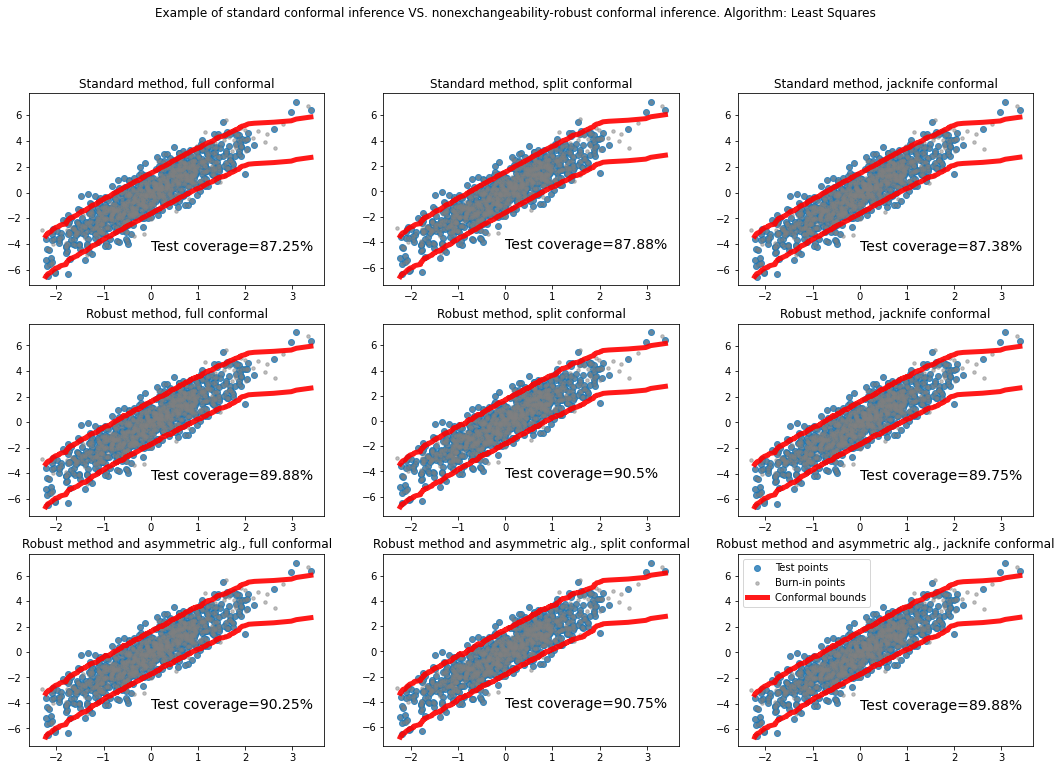

In [616]:
ex1_iid.plot_example(smooth = 20)

In [617]:
## Case 2 - Changepoints
changepoints = np.r_[80,160]
n_changepoint = len(changepoints)
beta_2 = np.array([[2],[-2],[0.5]])
X = np.random.normal(size=(N,p))
noise = np.random.normal(size=N)
Y = np.concatenate((
    X[:changepoints[0],:].dot(beta_2[0]) + noise[:changepoints[0]],
    X[changepoints[0]:changepoints[1],:].dot(beta_2[1]) + noise[changepoints[0]:changepoints[1]],
    X[changepoints[1]:,:].dot(beta_2[2]) + noise[changepoints[1]:]
    ))

ex1_changepoints = Example(X, Y)
ex1_changepoints.fit_conformal()

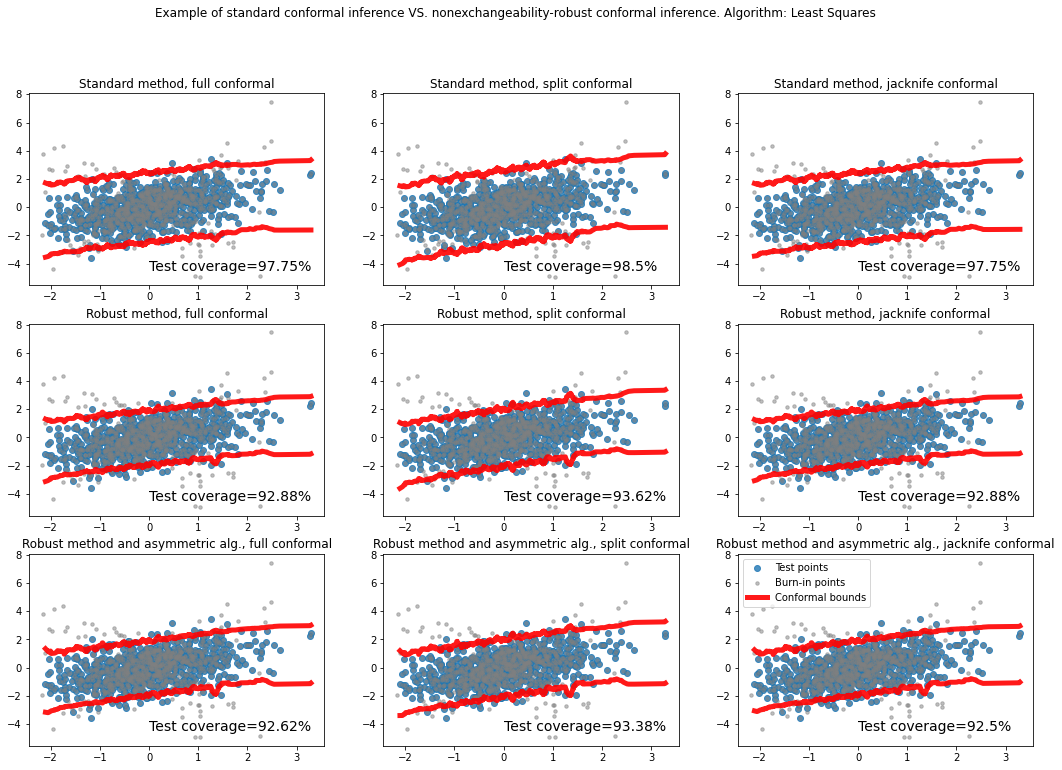

In [618]:
ex1_changepoints.plot_example(smooth=20)

In [621]:
N = 800
# setting 3: distribution drift
beta_start = np.array([2])
beta_end = np.array([-2])
beta_3 = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)
X = np.random.normal(scale = 4, size=(N,p))
noise = np.random.normal(size=N)
Y = np.zeros(N)
for i in np.arange(N):
    Y[i] = X[i].dot(beta_3[i]) + noise[i]


ex1_drift = Example(X, Y, rho = 0.99, rho_LS = 0.9, train_lag=300)
ex1_drift.fit_conformal()

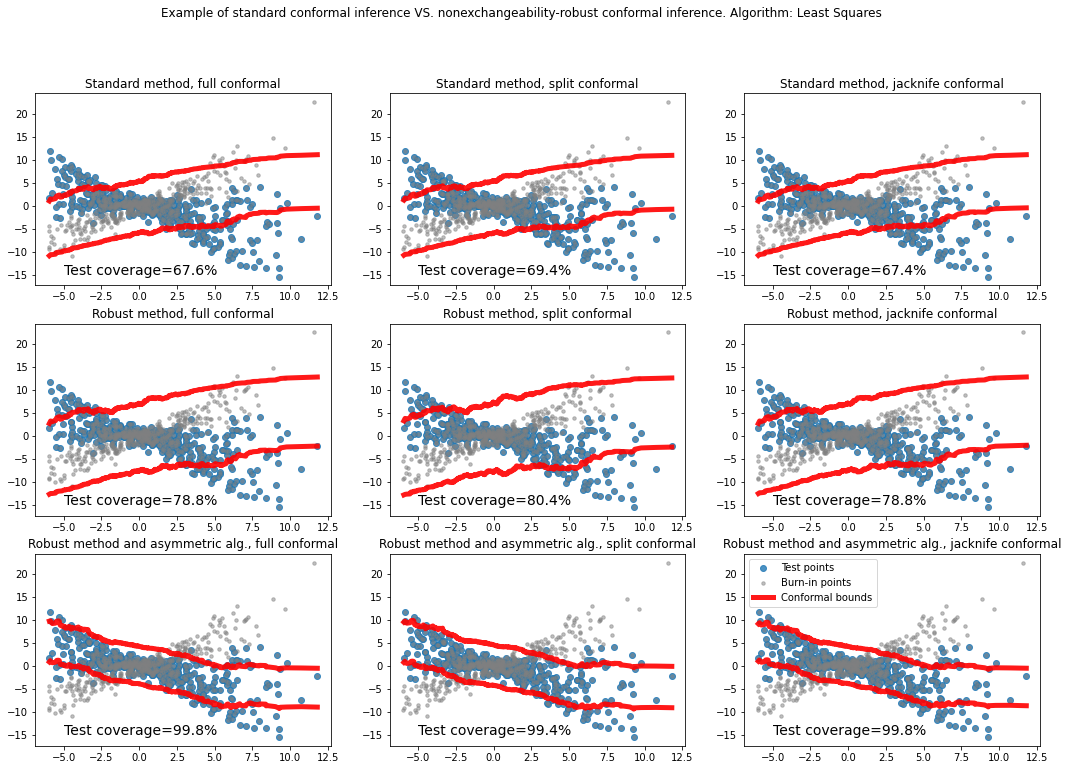

In [622]:
ex1_drift.plot_example(smooth = 40, annotation_pos = (-5, -15))